In [ ]:
##########################################
# Fama French 3 Factors-CRSP New Format  #
# Qingyi (Freda) Song Drechsler          #
# Date: August 2022                      #
# Updated:                               #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
#import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

In [ ]:
conn = wrds.Connection()

Loading library list...
Done


In [ ]:
###################
# Compustat Block #
###################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1959'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year

In [ ]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

In [ ]:
# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

In [ ]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [ ]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.mthcaldt, 
                      a.issuertype, a.securitytype, a.securitysubtype, a.sharetype, a.usincflg, 
                      a.primaryexch, a.conditionaltype, a.tradingstatusflg,
                      a.mthret, a.mthretx, a.shrout, a.mthprc
                      from crsp.msf_v2 as a
                      where a.mthcaldt between '01/01/1959' and '12/31/2022'
                      """, date_cols=['mthcaldt']) 

crsp_m.shape

(4493240, 15)

### Select common stock universe
- equivalent to legacy code shrcd = 10 or 11

In [ ]:
crsp_m = crsp_m.loc[(crsp_m.sharetype=='NS') & \
                    (crsp_m.securitytype=='EQTY') & \
                    (crsp_m.securitysubtype=='COM') & \
                    (crsp_m.usincflg=='Y') & \
                    (crsp_m.issuertype.isin(['ACOR', 'CORP']))]
crsp_m.shape

(3435658, 15)

### Select stocks traded on NYSE, AMEX and NASDAQ
- equivalent to legacy code exchcd = 1, 2 or 3

In [ ]:
crsp_m = crsp_m.loc[(crsp_m.primaryexch.isin(['N', 'A', 'Q'])) & \
                   (crsp_m.conditionaltype =='RW') & \
                   (crsp_m.tradingstatusflg =='A')]
crsp_m.shape

(3375265, 15)

In [ ]:
# change variable format to int
crsp_m[['permco','permno']]=crsp_m[['permco','permno']].astype(int)

# Line up date to be end of month
crsp_m['jdate']=crsp_m['mthcaldt']+MonthEnd(0)

### No need to add delisting return in the new CIZ CRSP format
- last trading return and price prior to delisting are already part of the time series output

In [ ]:
# calculate market equity
crsp = crsp_m.copy()

crsp['mthret']=crsp['mthret'].fillna(0)
crsp['mthretx']=crsp['mthretx'].fillna(0)
crsp['me']=crsp['mthprc']*crsp['shrout'] 
crsp=crsp.drop(['mthprc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [ ]:
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

In [ ]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','mthcaldt','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['mthretx']
crsp2=crsp2.sort_values(by=['permno','mthcaldt'])

In [ ]:
# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [ ]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','mthcaldt', 'jdate', 'sharetype', 'securitytype', 'securitysubtype', 'usincflg', 'issuertype', \
                   'primaryexch', 'conditionaltype', 'tradingstatusflg', \
                   'mthret','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [ ]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [ ]:
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

In [ ]:
# select NYSE stocks for bucket breakdown
# legacy data format: exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
# new CIZ format: primaryexch == 'N', positive beme, positive me, at least 2 years in comp
# shrcd in 10 and 11 is already handled in the code earlier

nyse=ccm_jun[(ccm_jun['primaryexch']=='N') & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1)]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

In [ ]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [ ]:
# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [ ]:
# store portfolio assignment as of June

june=ccm1_jun[['permno','mthcaldt', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['mthcaldt','permno', 'sharetype', 'securitytype', 'securitysubtype', 'usincflg', 'issuertype', \
               'primaryexch', 'conditionaltype', 'tradingstatusflg', \
               'mthret', 'me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1)]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
############################
# Form Fama French Factors #
############################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [ ]:
# value-weigthed return
vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'mthret','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['mthret'].count().reset_index().rename(columns={'mthret':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']


In [ ]:
# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [ ]:
###################
# Compare With FF #
###################
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

_ffcomp = pd.merge(_ff, ff_factors[['date','WSMB','WHML']], how='inner', on='date')
_ffcomp70=_ffcomp[_ffcomp['date']>='01/01/1970']


print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))

(0.995890798273324, 0.0)
(0.9841110969736341, 0.0)


In [ ]:
_ffcomp.set_index('date', inplace=True)
_ffcomp.tail(2)

,smb,hml,WSMB,WHML
date,,,,
2022-05-31,-0.0187,0.0838,-0.016452,0.084156
2022-06-30,0.0209,-0.0593,0.018867,-0.056672


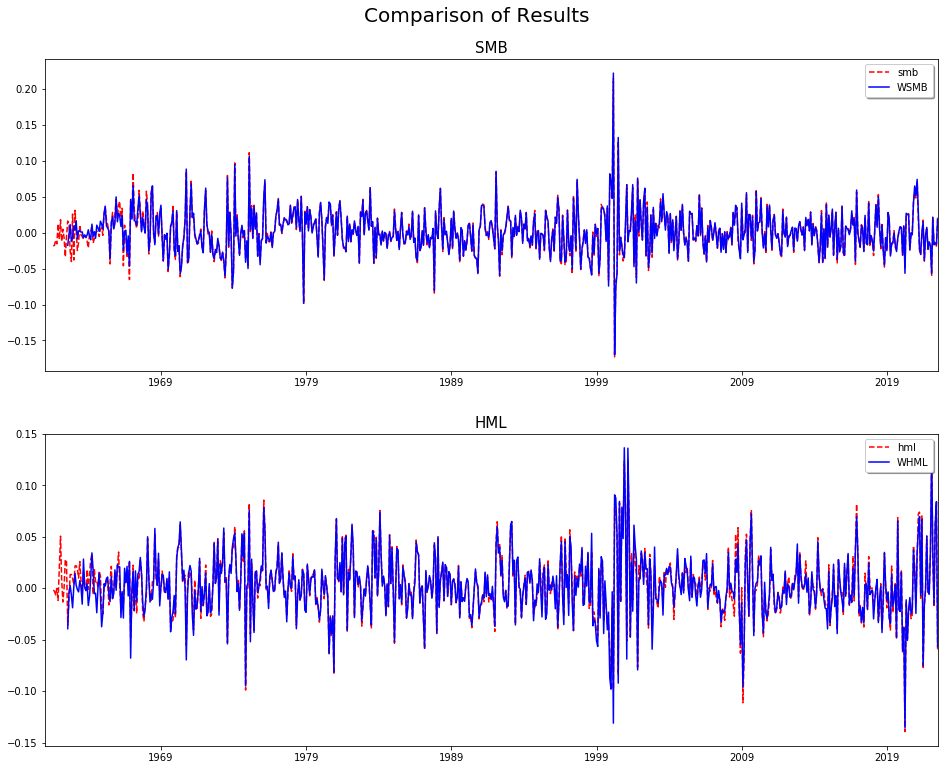

In [ ]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('SMB', fontsize=15)
ax1.set_xlim([dt.datetime(1961,1,1), dt.datetime(2022,6,30)])
ax1.plot(_ffcomp['smb'], 'r--', _ffcomp['WSMB'], 'b-')
ax1.legend(('smb','WSMB'), loc='upper right', shadow=True)

ax2 = plt.subplot(212)
ax2.set_title('HML', fontsize=15)
ax2.plot(_ffcomp['hml'], 'r--', _ffcomp['WHML'], 'b-')
ax2.set_xlim([dt.datetime(1961,1,1), dt.datetime(2022,6,30)])
ax2.legend(('hml','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()